In [159]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf

In [161]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 100000

In [162]:
# generate steps for all particles
steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))

In [163]:
# initial positions
x = 2*L*np.random.random(size=(N,))

In [164]:
# put initial position in front
x = np.column_stack((x, steps))

In [165]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),2*L)-L

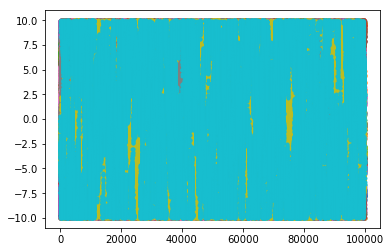

In [166]:
for path in paths:
    plt.plot(path,".")

In [167]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=0)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

0.966969468824
1.0


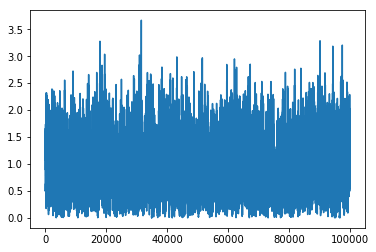

In [168]:
plt.plot(intensity)
print(intensity.mean())
# what should it be
print(N/2/L)

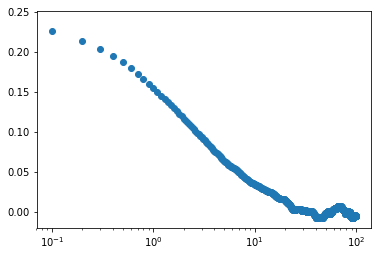

In [169]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:1000]-1.0
t = np.arange(0,autocorr.size)*dt
plt.semilogx(t,autocorr,"o")

In [170]:
print(autocorr[0]/N*L)
print(L/autocorr[0]/N)
print(autocorr[0]*N/L*2*np.sqrt(np.pi))
print(L/autocorr[0]/N/np.sqrt(np.pi))

0.119514185503
2.09180189738
1.69466702667
1.18017284135


In [171]:
# this is the model that describes the ideal case if infinite boundary conditions
def corrfit(t,N,D,gamma,w0):
    return 1/N/(1+(D*t/w0**2))**gamma

In [179]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 20
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [180]:
corrfitPB_model=lm.Model(corrfitPB)
paramsPB = corrfitPB_model.make_params()
paramsPB['w0'].set(value=1,vary=False)
paramsPB['N'].set(value=20,vary=True)
paramsPB['D'].set(value=D,vary=True)
paramsPB['L'].set(value=L,vary=False)

resultPB = corrfitPB_model.fit(t=t,data=autocorr,params=paramsPB)

In [181]:
print(resultPB.fit_report())

[[Model]]
    Model(corrfitPB)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 1000
    # variables        = 2
    chi-square         = 0.017
    reduced chi-square = 0.000
    Akaike info crit   = -10950.425
    Bayesian info crit = -10940.610
[[Variables]]
    N:    18.8684159 +/- 0.126617 (0.67%) (init= 20)
    D:    1.08887449 +/- 0.011703 (1.07%) (init= 1)
    w0:   1 (fixed)
    L:    10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.775 



In [175]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=1,vary=False)
params['N'].set(value=5,vary=True)
params['D'].set(value=1,vary=True)
params['gamma'].set(value=0.5,vary=False)

result = corrfit_model.fit(t=t,data=autocorr,params=params)

In [176]:
print(result.fit_report())

[[Model]]
    Model(corrfit)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 1000
    # variables        = 2
    chi-square         = 0.280
    reduced chi-square = 0.000
    Akaike info crit   = -8175.229
    Bayesian info crit = -8165.413
[[Variables]]
    N:       3.36334179 +/- 0.173235 (5.15%) (init= 5)
    D:       9.16806869 +/- 1.111931 (12.13%) (init= 1)
    gamma:   0.5 (fixed)
    w0:      1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.922 



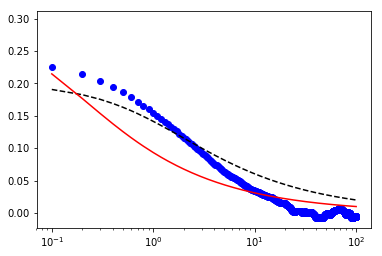

In [177]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')

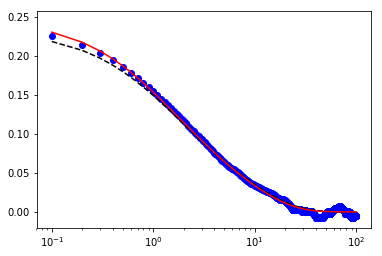

In [182]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, resultPB.init_fit, 'k--')
plt.semilogx(t, resultPB.best_fit, 'r-')